# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/177/EEGNet_lstm/1-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment
- Same subject, same session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- Same subject, new session: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment
- Same subject, new session: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)
- New subject: EEGNet bidirectional LSTM
   - Results
   - Longer window experiment
- New subject: EEGNet with bidirectional ConvLSTM2D
   - Results
   - Longer window experiment (TODO)

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8021 @ epoch 75                         | 0.5685 @ epoch 170                    | 0.7083                                                | 0.7135                                                 |
| C           | 0.901 @ epoch 301                         | 0.3569 @ epoch 376                    | 0.9062                                                | 0.8958                                                 |
| E           | 0.9058 @ epoch 478                        | 0.3463 @ epoch 400                    | 0.8272                                                | 0.8272                                                 |

With comparable results it is clear that the extension didn't yield improvements nor caused any major issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
This is to be expected given the amount of trainable parameters is increased in such an extreme manner.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.

The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 128 (from 64)
   - Further increase to 192 was not beneficial in this experiment 

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8802 @ epoch 383                   | 0.3736 @ epoch 632               | 0.7708                                           | 0.7812                                            |
| C           | 0.9479 @ epoch 2290                  | 0.2454 @ epoch 1094              | 0.9531                                           | 0.9375                                            |
| E           | 0.9529 @ epoch 896                   | 0.1631 @ epoch 1224              | 0.9319                                           | 0.9215                                            |

EEGNet with LSTM:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8385 @ epoch 350                   | 0.5532 @ epoch 360               | 0.7396                                           | 0.75                                              |
| C           | 0.8958 @ epoch 920                   | 0.3792 @ epoch 664               | 0.8594                                           | 0.8802                                            |
| E           | 0.9058 @ epoch 81                    | 0.3552 @ epoch 273               | 0.8115                                           | 0.8272                                            |

Whilst the accuracy improved for the test set significantly for subject C and E, the added complexity and overfitting tendencies is something that should be taken into account when working with longer windows.

The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss_long.png)

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 128, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 300, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 16, # number of temporal filters. (default: 8)
        F2 = 32, # number of pointwise filters. (default: 16)
        D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.3, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        LSTM_size = 128, # Amount of units in LSTM layer
        ltsm_dropout = 0.6,
        ltsm_l1 = 0.0005,
        ltsm_l2 = 0.0005
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_long_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.8177 @ epoch 448                             | 0.5194 @ epoch 345                         | 0.7083                                                     | 0.6927                                                      |
| C           | 0.8906 @ epoch 187                             | 0.3887 @ epoch 44                          | 0.8854                                                     | 0.8854                                                      |
| E           | 0.9215 @ epoch 339                             | 0.2673 @ epoch 443                         | 0.8429                                                     | 0.8639                                                      |


Again, for the most part results seems comparable although the result for subject B is considerably lower then EEGNet.
The training plots for the validation scores are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_samesession/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 2500 epochs due to the increased amount of data, saving the best model based on best validation accuracy and validation loss (0.3 validation split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6458 @ epoch 177                             | 0.8297 @ epoch 147                         | 0.6302                                                     | 0.6188                                                      |
| C           | 0.8681 @ epoch 947                             | 0.4117 @ epoch 782                         | 0.6726                                                     | 0.6851                                                      |
| E           | 0.7361 @ epoch 166                             | 0.6617 @ epoch 75                          | 0.6513                                                     | 0.6702                                                      |

Again, no real increase nor decrease in performance is made with the LSTM extension

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 192 (from 64)
   - Increase to 192 was beneficial in this experiment due to increased data complexity

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.7378 @ epoch 2483                  | 0.6887 @ epoch 204               | 0.6677                                           | 0.674                                             |
| C           | 0.9149 @ epoch 885                   | 0.3764 @ epoch 208               | 0.6392                                           | 0.6267                                            |
| E           | 0.8333 @ epoch 233                   | 0.4867 @ epoch 302               | 0.7707                                           | 0.7812                                            |

EEGNet with LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.6892 @ epoch 246                        | 0.8028 @ epoch 108                    | 0.6573                                                | 0.6406                                                 |
| C           | 0.875 @ epoch 53                          | 0.4447 @ epoch 285                    | 0.6548                                                | 0.6434                                                 |
| E           | 0.7934 @ epoch 197                        | 0.5842 @ epoch 96                     | 0.6932                                                | 0.6827                                                 |

The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_newsession/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_newsession/loss_long.png)

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_longer_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_differentsession_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Same subject, new session: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 500 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get all training data (all but last session of participant)
                        mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Combine training data into singular mne raw
                        mne_raw = mne.concatenate_raws(mne_raws)
                        
                        # Delete all raws since concat changes them
                        del mne_raws
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 500, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

EEGNet

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Model performance with the LSTM extension seems to be worse

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/samesubject_newsession/Accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/samesubject_newsession/Loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet bidirectional LSTM

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - LSTM_size = 64
         - lstm_dropout = 0.6
         - lstm_l1 = 0.0005
         - lstm_l2 = 0.0005
      - We trained for 1000 epochs due to the increased training time compared to EEGNet and the fast convergence, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.7648 @ epoch 128                        | 0.6107 @ epoch 175                    | 0.6635                                                | 0.6552                                                 |
| C           | 0.7486 @ epoch 6                          | 0.7044 @ epoch 157                    | 0.5985                                                | 0.5746                                                 |
| E           | 0.7182 @ epoch 72                         | 0.7053 @ epoch 80                     | 0.6461                                                | 0.6534                                                 |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_lstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

#### Longer window experiment

An experiment was performed where the window size was changed to 1.5 seconds.
This is done by including 0.25 seconds before and after the queue is shown, totalling 0.25 + 1 + 0.25 = 1.5 seconds.
The following parameters were changed:
- Samples = 300 (from 100)
- kernLength = 150 (from 50)
- F1 = 16 (from 8)
- F2 = 32 (from 16)
- D = 4 (from 2)
- LSTM size = 192 (from 64)
   - Increase to 192 was beneficial in this experiment due to increased data complexity

The performed experiment is equal besides this.
The following results were obtained.

EEGNet:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.8001 @ epoch 438                   | 0.5408 @ epoch 493               | 0.6219                                           | 0.5979                                            |
| C (Train B&E) | 0.7578 @ epoch 292                   | 0.6006 @ epoch 294               | 0.5839                                           | 0.5714                                            |
| E (Train B&C) | 0.798 @ epoch 2206                   | 0.6026 @ epoch 1848              | 0.6147                                           | 0.6052                                            |

EEGNet with LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.7706 @ epoch 103                        | 0.6164 @ epoch 114                    | 0.6771                                                | 0.6698                                                 |
| C           | 0.7462 @ epoch 77                         | 0.6819 @ epoch 77                     | 0.6058                                                | 0.6058                                                 |
| E           | 0.7402 @ epoch 58                         | 0.6894 @ epoch 58                     | 0.666                                                 | 0.666                                                  |

These results are better then what is achieved with EEGNet.
The training plots are given below.
B is dark blue, C is light blue and E is green.


![Accuracy plot](figures/7/EEGNet_lstm/newsubject/accuracy_long.png)
![Loss plot](figures/7/EEGNet_lstm/newsubject/loss_long.png)

In [5]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 300, 16)       2400      
                                                                 
 batch_normalization (BatchN  (None, 21, 300, 16)      64        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 300, 64)       1344      
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 300, 64)       256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1, 300, 64)        0         
                                                        

In [7]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 300, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 150, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 16, # number of temporal filters. (default: 8)
    F2 = 32, # number of pointwise filters. (default: 16)
    D = 4, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.3, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 192, # Amount of units in LSTM layer
    ltsm_dropout = 0.6,
    ltsm_l1 = 0.0005,
    ltsm_l2 = 0.0005
    )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_newsubject_longer_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Using data from participants ['C', 'E'] to train for testing on participant B
Shape of all training data (epochs, channels, samples): (5751, 21, 300)
Epoch 1/1000
32/32 [==============================] - ETA: 0s - loss: 1.8740 - accuracy: 0.4539
Epoch 1: val_loss improved from inf to 1.48986, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.57184, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 10s 149ms/step - loss: 1.8740 - accuracy: 0.4539 - val_loss: 1.4899 - val_accuracy: 0.5718
Epoch 2/1000
31/32 [============================>.] - ETA: 0s - loss: 1.2129 - accuracy: 0.6184
Epoch 2: val_loss improved from 1.48986 to 1.13904, saving model to sav

Epoch 18/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5762 - accuracy: 0.7818
Epoch 18: val_loss improved from 0.67629 to 0.64377, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 18: val_accuracy improved from 0.73291 to 0.74739, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 3s 92ms/step - loss: 0.5781 - accuracy: 0.7809 - val_loss: 0.6438 - val_accuracy: 0.7474
Epoch 19/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5783 - accuracy: 0.7891
Epoch 19: val_loss did not improve from 0.64377

Epoch 19: val_accuracy did not improve from 0.74739
32/32 [==============================] - 3s 88ms/step - loss: 0.5797 - accuracy: 0.7881 - val_loss: 0.6613 - val_accuracy: 0.7462
Epoch 20/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5512 - accuracy: 0.7996
Epoch 20: val_los

31/32 [============================>.] - ETA: 0s - loss: 0.4908 - accuracy: 0.8251
Epoch 41: val_loss did not improve from 0.62550

Epoch 41: val_accuracy did not improve from 0.75377
32/32 [==============================] - 3s 86ms/step - loss: 0.4919 - accuracy: 0.8243 - val_loss: 0.6401 - val_accuracy: 0.7480
Epoch 42/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4825 - accuracy: 0.8294
Epoch 42: val_loss did not improve from 0.62550

Epoch 42: val_accuracy did not improve from 0.75377
32/32 [==============================] - 3s 88ms/step - loss: 0.4836 - accuracy: 0.8288 - val_loss: 0.6350 - val_accuracy: 0.7497
Epoch 43/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4785 - accuracy: 0.8344
Epoch 43: val_loss did not improve from 0.62550

Epoch 43: val_accuracy did not improve from 0.75377
32/32 [==============================] - 3s 88ms/step - loss: 0.4777 - accuracy: 0.8345 - val_loss: 0.6414 - val_accuracy: 0.7497
Epoch 44/1000
31/32 [=========


Epoch 65: val_accuracy did not improve from 0.76304
32/32 [==============================] - 3s 86ms/step - loss: 0.4692 - accuracy: 0.8417 - val_loss: 0.6552 - val_accuracy: 0.7445
Epoch 66/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8533
Epoch 66: val_loss did not improve from 0.61919

Epoch 66: val_accuracy did not improve from 0.76304
32/32 [==============================] - 3s 86ms/step - loss: 0.4492 - accuracy: 0.8542 - val_loss: 0.6413 - val_accuracy: 0.7561
Epoch 67/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4485 - accuracy: 0.8460
Epoch 67: val_loss improved from 0.61919 to 0.61896, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 67: val_accuracy did not improve from 0.76304
32/32 [==============================] - 3s 91ms/step - loss: 0.4488 - accuracy: 0.8452 - val_loss: 0.6190 - val_accuracy: 0.7584
Epoch 68/1000
31/32 [=========================

Epoch 90/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4051 - accuracy: 0.8695
Epoch 90: val_loss did not improve from 0.61896

Epoch 90: val_accuracy did not improve from 0.76709
32/32 [==============================] - 3s 89ms/step - loss: 0.4066 - accuracy: 0.8683 - val_loss: 0.6340 - val_accuracy: 0.7543
Epoch 91/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4160 - accuracy: 0.8564
Epoch 91: val_loss did not improve from 0.61896

Epoch 91: val_accuracy did not improve from 0.76709
32/32 [==============================] - 3s 89ms/step - loss: 0.4174 - accuracy: 0.8557 - val_loss: 0.6399 - val_accuracy: 0.7596
Epoch 92/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4220 - accuracy: 0.8627
Epoch 92: val_loss did not improve from 0.61896

Epoch 92: val_accuracy did not improve from 0.76709
32/32 [==============================] - 3s 88ms/step - loss: 0.4233 - accuracy: 0.8619 - val_loss: 0.6698 - val_accuracy: 0.7375
Epoch 93/1000
31

31/32 [============================>.] - ETA: 0s - loss: 0.3999 - accuracy: 0.8642
Epoch 114: val_loss improved from 0.61896 to 0.61644, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 114: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 90ms/step - loss: 0.3999 - accuracy: 0.8643 - val_loss: 0.6164 - val_accuracy: 0.7625
Epoch 115/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3980 - accuracy: 0.8697
Epoch 115: val_loss did not improve from 0.61644

Epoch 115: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.3953 - accuracy: 0.8711 - val_loss: 0.6346 - val_accuracy: 0.7607
Epoch 116/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3856 - accuracy: 0.8742
Epoch 116: val_loss did not improve from 0.61644

Epoch 116: val_accuracy did not improve from 0.77057
32/32 [==============================

32/32 [==============================] - 3s 87ms/step - loss: 0.3817 - accuracy: 0.8735 - val_loss: 0.6290 - val_accuracy: 0.7601
Epoch 139/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3915 - accuracy: 0.8695
Epoch 139: val_loss did not improve from 0.61644

Epoch 139: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.3912 - accuracy: 0.8701 - val_loss: 0.6421 - val_accuracy: 0.7578
Epoch 140/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3880 - accuracy: 0.8720
Epoch 140: val_loss did not improve from 0.61644

Epoch 140: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.3859 - accuracy: 0.8730 - val_loss: 0.6606 - val_accuracy: 0.7520
Epoch 141/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3882 - accuracy: 0.8720
Epoch 141: val_loss did not improve from 0.61644

Epoch 141: val_accuracy did not improve from 0.77057
32/32 [


Epoch 163: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3735 - accuracy: 0.8760 - val_loss: 0.6674 - val_accuracy: 0.7538
Epoch 164/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3740 - accuracy: 0.8793
Epoch 164: val_loss did not improve from 0.61644

Epoch 164: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.3727 - accuracy: 0.8800 - val_loss: 0.6663 - val_accuracy: 0.7480
Epoch 165/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3552 - accuracy: 0.8899
Epoch 165: val_loss did not improve from 0.61644

Epoch 165: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3581 - accuracy: 0.8887 - val_loss: 0.6668 - val_accuracy: 0.7474
Epoch 166/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3790 - accuracy: 0.8775
Epoch 166: val_loss did not improve from 0.61644

Epoch 

31/32 [============================>.] - ETA: 0s - loss: 0.3741 - accuracy: 0.8848
Epoch 188: val_loss did not improve from 0.61644

Epoch 188: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3734 - accuracy: 0.8847 - val_loss: 0.6780 - val_accuracy: 0.7532
Epoch 189/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3643 - accuracy: 0.8896
Epoch 189: val_loss did not improve from 0.61644

Epoch 189: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3632 - accuracy: 0.8902 - val_loss: 0.6889 - val_accuracy: 0.7317
Epoch 190/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3599 - accuracy: 0.8861
Epoch 190: val_loss did not improve from 0.61644

Epoch 190: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3588 - accuracy: 0.8870 - val_loss: 0.6883 - val_accuracy: 0.7346
Epoch 191/1000
31/32 [

Epoch 213/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3444 - accuracy: 0.8904
Epoch 213: val_loss did not improve from 0.61644

Epoch 213: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3444 - accuracy: 0.8904 - val_loss: 0.6724 - val_accuracy: 0.7509
Epoch 214/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3598 - accuracy: 0.8909
Epoch 214: val_loss did not improve from 0.61644

Epoch 214: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3597 - accuracy: 0.8902 - val_loss: 0.6647 - val_accuracy: 0.7561
Epoch 215/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8866
Epoch 215: val_loss did not improve from 0.61644

Epoch 215: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3514 - accuracy: 0.8872 - val_loss: 0.6841 - val_accuracy: 0.7474
Epoch 2

Epoch 238/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3388 - accuracy: 0.8959
Epoch 238: val_loss did not improve from 0.61644

Epoch 238: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3391 - accuracy: 0.8961 - val_loss: 0.6904 - val_accuracy: 0.7532
Epoch 239/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3586 - accuracy: 0.8929
Epoch 239: val_loss did not improve from 0.61644

Epoch 239: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.3566 - accuracy: 0.8937 - val_loss: 0.6820 - val_accuracy: 0.7543
Epoch 240/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.8982
Epoch 240: val_loss did not improve from 0.61644

Epoch 240: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.3373 - accuracy: 0.8981 - val_loss: 0.6695 - val_accuracy: 0.7538
Epoch 2

Epoch 263/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.9040
Epoch 263: val_loss did not improve from 0.61644

Epoch 263: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3355 - accuracy: 0.9043 - val_loss: 0.6865 - val_accuracy: 0.7491
Epoch 264/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3213 - accuracy: 0.9047
Epoch 264: val_loss did not improve from 0.61644

Epoch 264: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3202 - accuracy: 0.9051 - val_loss: 0.6858 - val_accuracy: 0.7404
Epoch 265/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8959
Epoch 265: val_loss did not improve from 0.61644

Epoch 265: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3410 - accuracy: 0.8959 - val_loss: 0.6828 - val_accuracy: 0.7468
Epoch 2

Epoch 288/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3271 - accuracy: 0.9055
Epoch 288: val_loss did not improve from 0.61644

Epoch 288: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3281 - accuracy: 0.9056 - val_loss: 0.6855 - val_accuracy: 0.7462
Epoch 289/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.9055
Epoch 289: val_loss did not improve from 0.61644

Epoch 289: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3274 - accuracy: 0.9051 - val_loss: 0.6932 - val_accuracy: 0.7497
Epoch 290/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.9068
Epoch 290: val_loss did not improve from 0.61644

Epoch 290: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.3152 - accuracy: 0.9068 - val_loss: 0.7050 - val_accuracy: 0.7404
Epoch 2

Epoch 313/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3186 - accuracy: 0.9065
Epoch 313: val_loss did not improve from 0.61644

Epoch 313: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3174 - accuracy: 0.9073 - val_loss: 0.6997 - val_accuracy: 0.7572
Epoch 314/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3274 - accuracy: 0.9062
Epoch 314: val_loss did not improve from 0.61644

Epoch 314: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.3283 - accuracy: 0.9061 - val_loss: 0.7421 - val_accuracy: 0.7294
Epoch 315/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3306 - accuracy: 0.9037
Epoch 315: val_loss did not improve from 0.61644

Epoch 315: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3327 - accuracy: 0.9029 - val_loss: 0.6981 - val_accuracy: 0.7532
Epoch 3

Epoch 338/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.9030
Epoch 338: val_loss did not improve from 0.61644

Epoch 338: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3320 - accuracy: 0.9036 - val_loss: 0.7148 - val_accuracy: 0.7410
Epoch 339/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.9136
Epoch 339: val_loss did not improve from 0.61644

Epoch 339: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3112 - accuracy: 0.9125 - val_loss: 0.7082 - val_accuracy: 0.7439
Epoch 340/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3258 - accuracy: 0.9080
Epoch 340: val_loss did not improve from 0.61644

Epoch 340: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3258 - accuracy: 0.9081 - val_loss: 0.7283 - val_accuracy: 0.7381
Epoch 3

Epoch 363/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.9161
Epoch 363: val_loss did not improve from 0.61644

Epoch 363: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2969 - accuracy: 0.9163 - val_loss: 0.7058 - val_accuracy: 0.7543
Epoch 364/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3037 - accuracy: 0.9166
Epoch 364: val_loss did not improve from 0.61644

Epoch 364: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 90ms/step - loss: 0.3051 - accuracy: 0.9158 - val_loss: 0.6985 - val_accuracy: 0.7468
Epoch 365/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.9131
Epoch 365: val_loss did not improve from 0.61644

Epoch 365: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.3196 - accuracy: 0.9125 - val_loss: 0.6896 - val_accuracy: 0.7567
Epoch 3

Epoch 388/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.9163
Epoch 388: val_loss did not improve from 0.61644

Epoch 388: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.3171 - accuracy: 0.9165 - val_loss: 0.7278 - val_accuracy: 0.7468
Epoch 389/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3195 - accuracy: 0.9146
Epoch 389: val_loss did not improve from 0.61644

Epoch 389: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.3183 - accuracy: 0.9153 - val_loss: 0.7143 - val_accuracy: 0.7422
Epoch 390/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3037 - accuracy: 0.9176
Epoch 390: val_loss did not improve from 0.61644

Epoch 390: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.3047 - accuracy: 0.9168 - val_loss: 0.7301 - val_accuracy: 0.7486
Epoch 3

Epoch 413/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.9231
Epoch 413: val_loss did not improve from 0.61644

Epoch 413: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 83ms/step - loss: 0.2836 - accuracy: 0.9225 - val_loss: 0.7359 - val_accuracy: 0.7596
Epoch 414/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2817 - accuracy: 0.9224
Epoch 414: val_loss did not improve from 0.61644

Epoch 414: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 84ms/step - loss: 0.2829 - accuracy: 0.9217 - val_loss: 0.7416 - val_accuracy: 0.7422
Epoch 415/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2835 - accuracy: 0.9239
Epoch 415: val_loss did not improve from 0.61644

Epoch 415: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 83ms/step - loss: 0.2832 - accuracy: 0.9240 - val_loss: 0.7276 - val_accuracy: 0.7358
Epoch 4

Epoch 438/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.9224
Epoch 438: val_loss did not improve from 0.61644

Epoch 438: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.3026 - accuracy: 0.9227 - val_loss: 0.7727 - val_accuracy: 0.7491
Epoch 439/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.9332
Epoch 439: val_loss did not improve from 0.61644

Epoch 439: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2898 - accuracy: 0.9334 - val_loss: 0.7533 - val_accuracy: 0.7578
Epoch 440/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.9307
Epoch 440: val_loss did not improve from 0.61644

Epoch 440: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2818 - accuracy: 0.9312 - val_loss: 0.7630 - val_accuracy: 0.7341
Epoch 4

Epoch 463/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.9259
Epoch 463: val_loss did not improve from 0.61644

Epoch 463: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2975 - accuracy: 0.9257 - val_loss: 0.7627 - val_accuracy: 0.7532
Epoch 464/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2939 - accuracy: 0.9315
Epoch 464: val_loss did not improve from 0.61644

Epoch 464: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2935 - accuracy: 0.9314 - val_loss: 0.7750 - val_accuracy: 0.7468
Epoch 465/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.9284
Epoch 465: val_loss did not improve from 0.61644

Epoch 465: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.2883 - accuracy: 0.9275 - val_loss: 0.7790 - val_accuracy: 0.7457
Epoch 4

Epoch 488/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.9327
Epoch 488: val_loss did not improve from 0.61644

Epoch 488: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2759 - accuracy: 0.9324 - val_loss: 0.7236 - val_accuracy: 0.7590
Epoch 489/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.9282
Epoch 489: val_loss did not improve from 0.61644

Epoch 489: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2766 - accuracy: 0.9277 - val_loss: 0.7132 - val_accuracy: 0.7538
Epoch 490/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.9340
Epoch 490: val_loss did not improve from 0.61644

Epoch 490: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2762 - accuracy: 0.9347 - val_loss: 0.7482 - val_accuracy: 0.7538
Epoch 4

Epoch 513/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2874 - accuracy: 0.9264
Epoch 513: val_loss did not improve from 0.61644

Epoch 513: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2886 - accuracy: 0.9262 - val_loss: 0.8275 - val_accuracy: 0.7260
Epoch 514/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3135 - accuracy: 0.9262
Epoch 514: val_loss did not improve from 0.61644

Epoch 514: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.3128 - accuracy: 0.9262 - val_loss: 0.8022 - val_accuracy: 0.7393
Epoch 515/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2856 - accuracy: 0.9370
Epoch 515: val_loss did not improve from 0.61644

Epoch 515: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2851 - accuracy: 0.9369 - val_loss: 0.7966 - val_accuracy: 0.7358
Epoch 5

Epoch 538/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2626 - accuracy: 0.9383
Epoch 538: val_loss did not improve from 0.61644

Epoch 538: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.2625 - accuracy: 0.9381 - val_loss: 0.7682 - val_accuracy: 0.7439
Epoch 539/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.9375
Epoch 539: val_loss did not improve from 0.61644

Epoch 539: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2606 - accuracy: 0.9371 - val_loss: 0.8037 - val_accuracy: 0.7416
Epoch 540/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2491 - accuracy: 0.9395
Epoch 540: val_loss did not improve from 0.61644

Epoch 540: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2505 - accuracy: 0.9389 - val_loss: 0.8132 - val_accuracy: 0.7428
Epoch 5

Epoch 563/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9493
Epoch 563: val_loss did not improve from 0.61644

Epoch 563: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2316 - accuracy: 0.9493 - val_loss: 0.8005 - val_accuracy: 0.7480
Epoch 564/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9456
Epoch 564: val_loss did not improve from 0.61644

Epoch 564: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2334 - accuracy: 0.9453 - val_loss: 0.8726 - val_accuracy: 0.7231
Epoch 565/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2416 - accuracy: 0.9428
Epoch 565: val_loss did not improve from 0.61644

Epoch 565: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.2424 - accuracy: 0.9421 - val_loss: 0.8323 - val_accuracy: 0.7242
Epoch 5

Epoch 588/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2591 - accuracy: 0.9456
Epoch 588: val_loss did not improve from 0.61644

Epoch 588: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2601 - accuracy: 0.9451 - val_loss: 0.8541 - val_accuracy: 0.7277
Epoch 589/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.9531
Epoch 589: val_loss did not improve from 0.61644

Epoch 589: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2446 - accuracy: 0.9533 - val_loss: 0.8178 - val_accuracy: 0.7422
Epoch 590/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9420
Epoch 590: val_loss did not improve from 0.61644

Epoch 590: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2657 - accuracy: 0.9419 - val_loss: 0.7759 - val_accuracy: 0.7451
Epoch 5

Epoch 613/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2311 - accuracy: 0.9509
Epoch 613: val_loss did not improve from 0.61644

Epoch 613: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2303 - accuracy: 0.9508 - val_loss: 0.8178 - val_accuracy: 0.7381
Epoch 614/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9529
Epoch 614: val_loss did not improve from 0.61644

Epoch 614: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2212 - accuracy: 0.9530 - val_loss: 0.8082 - val_accuracy: 0.7404
Epoch 615/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2213 - accuracy: 0.9511
Epoch 615: val_loss did not improve from 0.61644

Epoch 615: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2213 - accuracy: 0.9508 - val_loss: 0.7798 - val_accuracy: 0.7491
Epoch 6

Epoch 638/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2292 - accuracy: 0.9554
Epoch 638: val_loss did not improve from 0.61644

Epoch 638: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2284 - accuracy: 0.9558 - val_loss: 0.8335 - val_accuracy: 0.7410
Epoch 639/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9592
Epoch 639: val_loss did not improve from 0.61644

Epoch 639: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.2084 - accuracy: 0.9588 - val_loss: 0.8280 - val_accuracy: 0.7399
Epoch 640/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9577
Epoch 640: val_loss did not improve from 0.61644

Epoch 640: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.2079 - accuracy: 0.9580 - val_loss: 0.8576 - val_accuracy: 0.7457
Epoch 6

Epoch 663/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9602
Epoch 663: val_loss did not improve from 0.61644

Epoch 663: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2060 - accuracy: 0.9602 - val_loss: 0.8555 - val_accuracy: 0.7329
Epoch 664/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9471
Epoch 664: val_loss did not improve from 0.61644

Epoch 664: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2401 - accuracy: 0.9473 - val_loss: 0.8462 - val_accuracy: 0.7335
Epoch 665/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2365 - accuracy: 0.9579
Epoch 665: val_loss did not improve from 0.61644

Epoch 665: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2369 - accuracy: 0.9578 - val_loss: 0.8437 - val_accuracy: 0.7341
Epoch 6

Epoch 688/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.9498
Epoch 688: val_loss did not improve from 0.61644

Epoch 688: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2433 - accuracy: 0.9498 - val_loss: 0.8291 - val_accuracy: 0.7387
Epoch 689/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9587
Epoch 689: val_loss did not improve from 0.61644

Epoch 689: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2207 - accuracy: 0.9588 - val_loss: 0.8543 - val_accuracy: 0.7387
Epoch 690/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9609
Epoch 690: val_loss did not improve from 0.61644

Epoch 690: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2134 - accuracy: 0.9612 - val_loss: 0.8655 - val_accuracy: 0.7416
Epoch 6

Epoch 713/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9630
Epoch 713: val_loss did not improve from 0.61644

Epoch 713: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2055 - accuracy: 0.9635 - val_loss: 0.8289 - val_accuracy: 0.7399
Epoch 714/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2034 - accuracy: 0.9637
Epoch 714: val_loss did not improve from 0.61644

Epoch 714: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2049 - accuracy: 0.9632 - val_loss: 0.8410 - val_accuracy: 0.7445
Epoch 715/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9652
Epoch 715: val_loss did not improve from 0.61644

Epoch 715: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1951 - accuracy: 0.9652 - val_loss: 0.8209 - val_accuracy: 0.7404
Epoch 7

Epoch 738/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9572
Epoch 738: val_loss did not improve from 0.61644

Epoch 738: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2043 - accuracy: 0.9563 - val_loss: 0.8892 - val_accuracy: 0.7480
Epoch 739/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9569
Epoch 739: val_loss did not improve from 0.61644

Epoch 739: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2226 - accuracy: 0.9563 - val_loss: 0.8715 - val_accuracy: 0.7375
Epoch 740/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9597
Epoch 740: val_loss did not improve from 0.61644

Epoch 740: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2301 - accuracy: 0.9595 - val_loss: 0.8457 - val_accuracy: 0.7375
Epoch 7

Epoch 763/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9650
Epoch 763: val_loss did not improve from 0.61644

Epoch 763: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2136 - accuracy: 0.9655 - val_loss: 0.8426 - val_accuracy: 0.7381
Epoch 764/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2130 - accuracy: 0.9624
Epoch 764: val_loss did not improve from 0.61644

Epoch 764: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2120 - accuracy: 0.9630 - val_loss: 0.8905 - val_accuracy: 0.7329
Epoch 765/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9670
Epoch 765: val_loss did not improve from 0.61644

Epoch 765: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1880 - accuracy: 0.9670 - val_loss: 0.8849 - val_accuracy: 0.7387
Epoch 7

Epoch 788/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1924 - accuracy: 0.9672
Epoch 788: val_loss did not improve from 0.61644

Epoch 788: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1925 - accuracy: 0.9672 - val_loss: 0.9084 - val_accuracy: 0.7381
Epoch 789/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9632
Epoch 789: val_loss did not improve from 0.61644

Epoch 789: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.2198 - accuracy: 0.9635 - val_loss: 0.9145 - val_accuracy: 0.7196
Epoch 790/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9657
Epoch 790: val_loss did not improve from 0.61644

Epoch 790: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.2144 - accuracy: 0.9660 - val_loss: 0.9332 - val_accuracy: 0.7352
Epoch 7

Epoch 813/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1966 - accuracy: 0.9677
Epoch 813: val_loss did not improve from 0.61644

Epoch 813: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1957 - accuracy: 0.9682 - val_loss: 0.8906 - val_accuracy: 0.7352
Epoch 814/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9690
Epoch 814: val_loss did not improve from 0.61644

Epoch 814: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1828 - accuracy: 0.9689 - val_loss: 0.8780 - val_accuracy: 0.7387
Epoch 815/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2056 - accuracy: 0.9665
Epoch 815: val_loss did not improve from 0.61644

Epoch 815: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.2051 - accuracy: 0.9667 - val_loss: 0.8983 - val_accuracy: 0.7387
Epoch 8

Epoch 838/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9730
Epoch 838: val_loss did not improve from 0.61644

Epoch 838: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1700 - accuracy: 0.9732 - val_loss: 0.8821 - val_accuracy: 0.7393
Epoch 839/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9703
Epoch 839: val_loss did not improve from 0.61644

Epoch 839: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1766 - accuracy: 0.9697 - val_loss: 0.9040 - val_accuracy: 0.7370
Epoch 840/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1747 - accuracy: 0.9715
Epoch 840: val_loss did not improve from 0.61644

Epoch 840: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1743 - accuracy: 0.9714 - val_loss: 0.9187 - val_accuracy: 0.7329
Epoch 8

Epoch 863/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9710
Epoch 863: val_loss did not improve from 0.61644

Epoch 863: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.1792 - accuracy: 0.9714 - val_loss: 0.8870 - val_accuracy: 0.7410
Epoch 864/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1609 - accuracy: 0.9776
Epoch 864: val_loss did not improve from 0.61644

Epoch 864: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.1604 - accuracy: 0.9779 - val_loss: 0.9328 - val_accuracy: 0.7277
Epoch 865/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9730
Epoch 865: val_loss did not improve from 0.61644

Epoch 865: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.1706 - accuracy: 0.9727 - val_loss: 0.8984 - val_accuracy: 0.7312
Epoch 8

Epoch 888/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1846 - accuracy: 0.9698
Epoch 888: val_loss did not improve from 0.61644

Epoch 888: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.1845 - accuracy: 0.9699 - val_loss: 0.8999 - val_accuracy: 0.7381
Epoch 889/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9735
Epoch 889: val_loss did not improve from 0.61644

Epoch 889: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1721 - accuracy: 0.9732 - val_loss: 0.8775 - val_accuracy: 0.7381
Epoch 890/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1812 - accuracy: 0.9710
Epoch 890: val_loss did not improve from 0.61644

Epoch 890: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1812 - accuracy: 0.9707 - val_loss: 0.8998 - val_accuracy: 0.7428
Epoch 8

Epoch 913/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1642 - accuracy: 0.9748
Epoch 913: val_loss did not improve from 0.61644

Epoch 913: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1636 - accuracy: 0.9749 - val_loss: 0.9175 - val_accuracy: 0.7352
Epoch 914/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9725
Epoch 914: val_loss did not improve from 0.61644

Epoch 914: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1685 - accuracy: 0.9724 - val_loss: 0.9338 - val_accuracy: 0.7236
Epoch 915/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9703
Epoch 915: val_loss did not improve from 0.61644

Epoch 915: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1888 - accuracy: 0.9704 - val_loss: 0.9305 - val_accuracy: 0.7248
Epoch 9

Epoch 938/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1524 - accuracy: 0.9808
Epoch 938: val_loss did not improve from 0.61644

Epoch 938: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1529 - accuracy: 0.9804 - val_loss: 0.9303 - val_accuracy: 0.7323
Epoch 939/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9720
Epoch 939: val_loss did not improve from 0.61644

Epoch 939: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1613 - accuracy: 0.9719 - val_loss: 0.8836 - val_accuracy: 0.7358
Epoch 940/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9700
Epoch 940: val_loss did not improve from 0.61644

Epoch 940: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1775 - accuracy: 0.9697 - val_loss: 0.9019 - val_accuracy: 0.7381
Epoch 9

Epoch 963/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9773
Epoch 963: val_loss did not improve from 0.61644

Epoch 963: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1532 - accuracy: 0.9774 - val_loss: 0.9259 - val_accuracy: 0.7254
Epoch 964/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9733
Epoch 964: val_loss did not improve from 0.61644

Epoch 964: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1581 - accuracy: 0.9737 - val_loss: 0.9044 - val_accuracy: 0.7364
Epoch 965/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9771
Epoch 965: val_loss did not improve from 0.61644

Epoch 965: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 87ms/step - loss: 0.1589 - accuracy: 0.9769 - val_loss: 0.9022 - val_accuracy: 0.7346
Epoch 9

Epoch 988/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9788
Epoch 988: val_loss did not improve from 0.61644

Epoch 988: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 84ms/step - loss: 0.1431 - accuracy: 0.9789 - val_loss: 0.9531 - val_accuracy: 0.7416
Epoch 989/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9735
Epoch 989: val_loss did not improve from 0.61644

Epoch 989: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 86ms/step - loss: 0.1550 - accuracy: 0.9729 - val_loss: 0.9259 - val_accuracy: 0.7242
Epoch 990/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1361 - accuracy: 0.9816
Epoch 990: val_loss did not improve from 0.61644

Epoch 990: val_accuracy did not improve from 0.77057
32/32 [==============================] - 3s 85ms/step - loss: 0.1361 - accuracy: 0.9811 - val_loss: 0.9428 - val_accuracy: 0.7370
Epoch 9

32/32 [==============================] - 3s 89ms/step - loss: 0.9439 - accuracy: 0.5835 - val_loss: 0.9083 - val_accuracy: 0.5782
Epoch 9/1000
31/32 [============================>.] - ETA: 0s - loss: 0.9181 - accuracy: 0.6081
Epoch 9: val_loss improved from 0.90835 to 0.88742, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 9: val_accuracy improved from 0.57937 to 0.60950, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 3s 90ms/step - loss: 0.9208 - accuracy: 0.6081 - val_loss: 0.8874 - val_accuracy: 0.6095
Epoch 10/1000
31/32 [============================>.] - ETA: 0s - loss: 0.9113 - accuracy: 0.6071
Epoch 10: val_loss improved from 0.88742 to 0.87069, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 10: val_accuracy did not improve from 0.60950
32

31/32 [============================>.] - ETA: 0s - loss: 0.7988 - accuracy: 0.6739
Epoch 29: val_loss did not improve from 0.73728

Epoch 29: val_accuracy did not improve from 0.70684
32/32 [==============================] - 3s 88ms/step - loss: 0.7995 - accuracy: 0.6730 - val_loss: 0.7826 - val_accuracy: 0.6744
Epoch 30/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7838 - accuracy: 0.6817
Epoch 30: val_loss did not improve from 0.73728

Epoch 30: val_accuracy did not improve from 0.70684
32/32 [==============================] - 3s 89ms/step - loss: 0.7845 - accuracy: 0.6804 - val_loss: 0.7667 - val_accuracy: 0.6802
Epoch 31/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7921 - accuracy: 0.6827
Epoch 31: val_loss did not improve from 0.73728

Epoch 31: val_accuracy did not improve from 0.70684
32/32 [==============================] - 3s 88ms/step - loss: 0.7932 - accuracy: 0.6809 - val_loss: 0.7623 - val_accuracy: 0.6889
Epoch 32/1000
31/32 [=========

Epoch 53/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7447 - accuracy: 0.6993
Epoch 53: val_loss did not improve from 0.70683

Epoch 53: val_accuracy did not improve from 0.72016
32/32 [==============================] - 3s 88ms/step - loss: 0.7455 - accuracy: 0.6993 - val_loss: 0.7767 - val_accuracy: 0.6918
Epoch 54/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.7084
Epoch 54: val_loss did not improve from 0.70683

Epoch 54: val_accuracy improved from 0.72016 to 0.72074, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 3s 89ms/step - loss: 0.7419 - accuracy: 0.7070 - val_loss: 0.7084 - val_accuracy: 0.7207
Epoch 55/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7392 - accuracy: 0.7009
Epoch 55: val_loss did not improve from 0.70683

Epoch 55: val_accuracy did not improve from 0.72074
32/32 [========================

Epoch 76/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7219 - accuracy: 0.7056
Epoch 76: val_loss did not improve from 0.68582

Epoch 76: val_accuracy did not improve from 0.73986
32/32 [==============================] - 3s 88ms/step - loss: 0.7215 - accuracy: 0.7053 - val_loss: 0.7534 - val_accuracy: 0.7010
Epoch 77/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7075 - accuracy: 0.7180
Epoch 77: val_loss improved from 0.68582 to 0.68189, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 77: val_accuracy improved from 0.73986 to 0.74623, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectC\trained_model_highest_acc_model.hdf5
32/32 [==============================] - 3s 92ms/step - loss: 0.7088 - accuracy: 0.7169 - val_loss: 0.6819 - val_accuracy: 0.7462
Epoch 78/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7137 - accuracy: 0.7124
Epoch 78: val_los

31/32 [============================>.] - ETA: 0s - loss: 0.6887 - accuracy: 0.7331
Epoch 100: val_loss did not improve from 0.68189

Epoch 100: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.6883 - accuracy: 0.7329 - val_loss: 0.7065 - val_accuracy: 0.7329
Epoch 101/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.7326
Epoch 101: val_loss did not improve from 0.68189

Epoch 101: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.6860 - accuracy: 0.7321 - val_loss: 0.7659 - val_accuracy: 0.6976
Epoch 102/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.7263
Epoch 102: val_loss did not improve from 0.68189

Epoch 102: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.6883 - accuracy: 0.7271 - val_loss: 0.7425 - val_accuracy: 0.7039
Epoch 103/1000
31/32 [

Epoch 125/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6636 - accuracy: 0.7482
Epoch 125: val_loss did not improve from 0.68189

Epoch 125: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 89ms/step - loss: 0.6639 - accuracy: 0.7475 - val_loss: 0.7266 - val_accuracy: 0.7190
Epoch 126/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.7450
Epoch 126: val_loss did not improve from 0.68189

Epoch 126: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.6625 - accuracy: 0.7450 - val_loss: 0.7220 - val_accuracy: 0.7231
Epoch 127/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6678 - accuracy: 0.7427
Epoch 127: val_loss did not improve from 0.68189

Epoch 127: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 89ms/step - loss: 0.6662 - accuracy: 0.7430 - val_loss: 0.7906 - val_accuracy: 0.6837
Epoch 1

Epoch 150/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.7606
Epoch 150: val_loss did not improve from 0.68189

Epoch 150: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.6294 - accuracy: 0.7612 - val_loss: 0.8198 - val_accuracy: 0.6744
Epoch 151/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6401 - accuracy: 0.7646
Epoch 151: val_loss did not improve from 0.68189

Epoch 151: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.6394 - accuracy: 0.7647 - val_loss: 0.7767 - val_accuracy: 0.7080
Epoch 152/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6449 - accuracy: 0.7576
Epoch 152: val_loss did not improve from 0.68189

Epoch 152: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.6428 - accuracy: 0.7580 - val_loss: 0.7893 - val_accuracy: 0.6848
Epoch 1

Epoch 175/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6240 - accuracy: 0.7724
Epoch 175: val_loss did not improve from 0.68189

Epoch 175: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.6230 - accuracy: 0.7736 - val_loss: 0.8501 - val_accuracy: 0.6640
Epoch 176/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6181 - accuracy: 0.7681
Epoch 176: val_loss did not improve from 0.68189

Epoch 176: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.6180 - accuracy: 0.7684 - val_loss: 0.7943 - val_accuracy: 0.7045
Epoch 177/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6209 - accuracy: 0.7739
Epoch 177: val_loss did not improve from 0.68189

Epoch 177: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.6218 - accuracy: 0.7739 - val_loss: 0.8662 - val_accuracy: 0.6547
Epoch 1

Epoch 200/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5866 - accuracy: 0.7936
Epoch 200: val_loss did not improve from 0.68189

Epoch 200: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.5889 - accuracy: 0.7925 - val_loss: 0.8327 - val_accuracy: 0.6784
Epoch 201/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5982 - accuracy: 0.7807
Epoch 201: val_loss did not improve from 0.68189

Epoch 201: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.5986 - accuracy: 0.7811 - val_loss: 0.8608 - val_accuracy: 0.6744
Epoch 202/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6012 - accuracy: 0.7797
Epoch 202: val_loss did not improve from 0.68189

Epoch 202: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.5995 - accuracy: 0.7806 - val_loss: 0.7711 - val_accuracy: 0.7051
Epoch 2

Epoch 225/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.7989
Epoch 225: val_loss did not improve from 0.68189

Epoch 225: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.5833 - accuracy: 0.7980 - val_loss: 0.8792 - val_accuracy: 0.6692
Epoch 226/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5779 - accuracy: 0.7944
Epoch 226: val_loss did not improve from 0.68189

Epoch 226: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.5778 - accuracy: 0.7942 - val_loss: 0.8467 - val_accuracy: 0.6848
Epoch 227/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5658 - accuracy: 0.8057
Epoch 227: val_loss did not improve from 0.68189

Epoch 227: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.5647 - accuracy: 0.8062 - val_loss: 0.8174 - val_accuracy: 0.6935
Epoch 2

Epoch 250/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5476 - accuracy: 0.8130
Epoch 250: val_loss did not improve from 0.68189

Epoch 250: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.5481 - accuracy: 0.8129 - val_loss: 0.8098 - val_accuracy: 0.7034
Epoch 251/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5614 - accuracy: 0.8120
Epoch 251: val_loss did not improve from 0.68189

Epoch 251: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.5626 - accuracy: 0.8106 - val_loss: 0.8589 - val_accuracy: 0.6808
Epoch 252/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5384 - accuracy: 0.8213
Epoch 252: val_loss did not improve from 0.68189

Epoch 252: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.5392 - accuracy: 0.8203 - val_loss: 0.8623 - val_accuracy: 0.6883
Epoch 2

Epoch 275/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5417 - accuracy: 0.8188
Epoch 275: val_loss did not improve from 0.68189

Epoch 275: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.5418 - accuracy: 0.8191 - val_loss: 0.8410 - val_accuracy: 0.6802
Epoch 276/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5298 - accuracy: 0.8304
Epoch 276: val_loss did not improve from 0.68189

Epoch 276: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.5287 - accuracy: 0.8310 - val_loss: 0.8935 - val_accuracy: 0.6645
Epoch 277/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5149 - accuracy: 0.8349
Epoch 277: val_loss did not improve from 0.68189

Epoch 277: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.5148 - accuracy: 0.8352 - val_loss: 0.9042 - val_accuracy: 0.6663
Epoch 2

Epoch 300/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5181 - accuracy: 0.8347
Epoch 300: val_loss did not improve from 0.68189

Epoch 300: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.5170 - accuracy: 0.8357 - val_loss: 0.9145 - val_accuracy: 0.6541
Epoch 301/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4893 - accuracy: 0.8483
Epoch 301: val_loss did not improve from 0.68189

Epoch 301: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.4883 - accuracy: 0.8489 - val_loss: 0.8522 - val_accuracy: 0.6889
Epoch 302/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.8440
Epoch 302: val_loss did not improve from 0.68189

Epoch 302: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.4995 - accuracy: 0.8437 - val_loss: 0.9110 - val_accuracy: 0.6616
Epoch 3

Epoch 325/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.8511
Epoch 325: val_loss did not improve from 0.68189

Epoch 325: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.4861 - accuracy: 0.8511 - val_loss: 0.9051 - val_accuracy: 0.6692
Epoch 326/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4636 - accuracy: 0.8601
Epoch 326: val_loss did not improve from 0.68189

Epoch 326: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.4634 - accuracy: 0.8603 - val_loss: 0.9165 - val_accuracy: 0.6645
Epoch 327/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4622 - accuracy: 0.8586
Epoch 327: val_loss did not improve from 0.68189

Epoch 327: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.4625 - accuracy: 0.8586 - val_loss: 0.9230 - val_accuracy: 0.6506
Epoch 3

Epoch 350/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4666 - accuracy: 0.8667
Epoch 350: val_loss did not improve from 0.68189

Epoch 350: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.4678 - accuracy: 0.8658 - val_loss: 0.9916 - val_accuracy: 0.6309
Epoch 351/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4318 - accuracy: 0.8831
Epoch 351: val_loss did not improve from 0.68189

Epoch 351: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.4325 - accuracy: 0.8822 - val_loss: 0.9440 - val_accuracy: 0.6501
Epoch 352/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4368 - accuracy: 0.8758
Epoch 352: val_loss did not improve from 0.68189

Epoch 352: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.4358 - accuracy: 0.8760 - val_loss: 0.8876 - val_accuracy: 0.6848
Epoch 3

Epoch 375/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4476 - accuracy: 0.8712
Epoch 375: val_loss did not improve from 0.68189

Epoch 375: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.4496 - accuracy: 0.8703 - val_loss: 0.9767 - val_accuracy: 0.6402
Epoch 376/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4419 - accuracy: 0.8783
Epoch 376: val_loss did not improve from 0.68189

Epoch 376: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.4424 - accuracy: 0.8780 - val_loss: 0.9858 - val_accuracy: 0.6454
Epoch 377/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4596 - accuracy: 0.8674
Epoch 377: val_loss did not improve from 0.68189

Epoch 377: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.4619 - accuracy: 0.8668 - val_loss: 0.9599 - val_accuracy: 0.6576
Epoch 3

Epoch 400/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4074 - accuracy: 0.8936
Epoch 400: val_loss did not improve from 0.68189

Epoch 400: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.4079 - accuracy: 0.8931 - val_loss: 0.9781 - val_accuracy: 0.6373
Epoch 401/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4008 - accuracy: 0.8989
Epoch 401: val_loss did not improve from 0.68189

Epoch 401: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.4002 - accuracy: 0.8989 - val_loss: 1.0159 - val_accuracy: 0.6292
Epoch 402/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4141 - accuracy: 0.8909
Epoch 402: val_loss did not improve from 0.68189

Epoch 402: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.4131 - accuracy: 0.8914 - val_loss: 1.0369 - val_accuracy: 0.6292
Epoch 4

Epoch 425/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3905 - accuracy: 0.8984
Epoch 425: val_loss did not improve from 0.68189

Epoch 425: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.3895 - accuracy: 0.8991 - val_loss: 0.9469 - val_accuracy: 0.6553
Epoch 426/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3779 - accuracy: 0.9047
Epoch 426: val_loss did not improve from 0.68189

Epoch 426: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.3780 - accuracy: 0.9043 - val_loss: 1.0104 - val_accuracy: 0.6489
Epoch 427/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8992
Epoch 427: val_loss did not improve from 0.68189

Epoch 427: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.3914 - accuracy: 0.8994 - val_loss: 1.0154 - val_accuracy: 0.6408
Epoch 4

Epoch 450/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3967 - accuracy: 0.8977
Epoch 450: val_loss did not improve from 0.68189

Epoch 450: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.3955 - accuracy: 0.8981 - val_loss: 1.0818 - val_accuracy: 0.6066
Epoch 451/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3866 - accuracy: 0.9055
Epoch 451: val_loss did not improve from 0.68189

Epoch 451: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.3863 - accuracy: 0.9048 - val_loss: 1.0116 - val_accuracy: 0.6402
Epoch 452/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3834 - accuracy: 0.9002
Epoch 452: val_loss did not improve from 0.68189

Epoch 452: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 88ms/step - loss: 0.3848 - accuracy: 0.8994 - val_loss: 1.0545 - val_accuracy: 0.6414
Epoch 4

Epoch 475/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3529 - accuracy: 0.9166
Epoch 475: val_loss did not improve from 0.68189

Epoch 475: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.3521 - accuracy: 0.9165 - val_loss: 1.0412 - val_accuracy: 0.6327
Epoch 476/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3503 - accuracy: 0.9153
Epoch 476: val_loss did not improve from 0.68189

Epoch 476: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.3513 - accuracy: 0.9150 - val_loss: 1.1049 - val_accuracy: 0.6159
Epoch 477/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3589 - accuracy: 0.9158
Epoch 477: val_loss did not improve from 0.68189

Epoch 477: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.3592 - accuracy: 0.9160 - val_loss: 1.0477 - val_accuracy: 0.6396
Epoch 4

Epoch 500/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3350 - accuracy: 0.9234
Epoch 500: val_loss did not improve from 0.68189

Epoch 500: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.3343 - accuracy: 0.9240 - val_loss: 1.0285 - val_accuracy: 0.6367
Epoch 501/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.9257
Epoch 501: val_loss did not improve from 0.68189

Epoch 501: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.3247 - accuracy: 0.9257 - val_loss: 1.0282 - val_accuracy: 0.6483
Epoch 502/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3315 - accuracy: 0.9214
Epoch 502: val_loss did not improve from 0.68189

Epoch 502: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.3312 - accuracy: 0.9215 - val_loss: 1.0471 - val_accuracy: 0.6390
Epoch 5

Epoch 525/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3535 - accuracy: 0.9221
Epoch 525: val_loss did not improve from 0.68189

Epoch 525: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.3532 - accuracy: 0.9227 - val_loss: 1.0472 - val_accuracy: 0.6350
Epoch 526/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3726 - accuracy: 0.9136
Epoch 526: val_loss did not improve from 0.68189

Epoch 526: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.3713 - accuracy: 0.9145 - val_loss: 1.0411 - val_accuracy: 0.6280
Epoch 527/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3778 - accuracy: 0.9161
Epoch 527: val_loss did not improve from 0.68189

Epoch 527: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.3777 - accuracy: 0.9165 - val_loss: 1.1226 - val_accuracy: 0.6199
Epoch 5

Epoch 550/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3567 - accuracy: 0.9204
Epoch 550: val_loss did not improve from 0.68189

Epoch 550: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.3549 - accuracy: 0.9212 - val_loss: 1.0757 - val_accuracy: 0.6333
Epoch 551/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.9267
Epoch 551: val_loss did not improve from 0.68189

Epoch 551: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.3368 - accuracy: 0.9267 - val_loss: 1.0365 - val_accuracy: 0.6304
Epoch 552/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3130 - accuracy: 0.9378
Epoch 552: val_loss did not improve from 0.68189

Epoch 552: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 83ms/step - loss: 0.3131 - accuracy: 0.9379 - val_loss: 1.0643 - val_accuracy: 0.6298
Epoch 5

Epoch 575/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.9400
Epoch 575: val_loss did not improve from 0.68189

Epoch 575: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2978 - accuracy: 0.9386 - val_loss: 1.1013 - val_accuracy: 0.6275
Epoch 576/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.9325
Epoch 576: val_loss did not improve from 0.68189

Epoch 576: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.3075 - accuracy: 0.9324 - val_loss: 1.0753 - val_accuracy: 0.6367
Epoch 577/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.9365
Epoch 577: val_loss did not improve from 0.68189

Epoch 577: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.3046 - accuracy: 0.9356 - val_loss: 1.0800 - val_accuracy: 0.6246
Epoch 5

Epoch 600/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.9375
Epoch 600: val_loss did not improve from 0.68189

Epoch 600: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.3076 - accuracy: 0.9379 - val_loss: 1.1074 - val_accuracy: 0.6188
Epoch 601/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.9423
Epoch 601: val_loss did not improve from 0.68189

Epoch 601: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2969 - accuracy: 0.9426 - val_loss: 1.1456 - val_accuracy: 0.6124
Epoch 602/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.9418
Epoch 602: val_loss did not improve from 0.68189

Epoch 602: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2969 - accuracy: 0.9416 - val_loss: 1.1294 - val_accuracy: 0.6037
Epoch 6

Epoch 625/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2818 - accuracy: 0.9453
Epoch 625: val_loss did not improve from 0.68189

Epoch 625: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2825 - accuracy: 0.9451 - val_loss: 1.1012 - val_accuracy: 0.6246
Epoch 626/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.9367
Epoch 626: val_loss did not improve from 0.68189

Epoch 626: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.3015 - accuracy: 0.9366 - val_loss: 1.0954 - val_accuracy: 0.6286
Epoch 627/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2895 - accuracy: 0.9443
Epoch 627: val_loss did not improve from 0.68189

Epoch 627: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2889 - accuracy: 0.9446 - val_loss: 1.0946 - val_accuracy: 0.6309
Epoch 6

Epoch 650/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.9375
Epoch 650: val_loss did not improve from 0.68189

Epoch 650: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.3012 - accuracy: 0.9379 - val_loss: 1.1387 - val_accuracy: 0.6141
Epoch 651/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.9388
Epoch 651: val_loss did not improve from 0.68189

Epoch 651: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.3006 - accuracy: 0.9376 - val_loss: 1.0918 - val_accuracy: 0.6240
Epoch 652/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.9478
Epoch 652: val_loss did not improve from 0.68189

Epoch 652: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 83ms/step - loss: 0.2770 - accuracy: 0.9473 - val_loss: 1.1586 - val_accuracy: 0.6182
Epoch 6

Epoch 675/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.9478
Epoch 675: val_loss did not improve from 0.68189

Epoch 675: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2661 - accuracy: 0.9478 - val_loss: 1.0658 - val_accuracy: 0.6396
Epoch 676/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.9393
Epoch 676: val_loss did not improve from 0.68189

Epoch 676: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2893 - accuracy: 0.9394 - val_loss: 1.0929 - val_accuracy: 0.6327
Epoch 677/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.9554
Epoch 677: val_loss did not improve from 0.68189

Epoch 677: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2607 - accuracy: 0.9550 - val_loss: 1.0712 - val_accuracy: 0.6454
Epoch 6

Epoch 700/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2562 - accuracy: 0.9514
Epoch 700: val_loss did not improve from 0.68189

Epoch 700: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.2554 - accuracy: 0.9520 - val_loss: 1.1779 - val_accuracy: 0.6246
Epoch 701/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2485 - accuracy: 0.9589
Epoch 701: val_loss did not improve from 0.68189

Epoch 701: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2478 - accuracy: 0.9592 - val_loss: 1.1263 - val_accuracy: 0.6327
Epoch 702/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.9466
Epoch 702: val_loss did not improve from 0.68189

Epoch 702: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.2786 - accuracy: 0.9453 - val_loss: 1.1221 - val_accuracy: 0.6333
Epoch 7

Epoch 725/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2646 - accuracy: 0.9546
Epoch 725: val_loss did not improve from 0.68189

Epoch 725: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2645 - accuracy: 0.9543 - val_loss: 1.1548 - val_accuracy: 0.6182
Epoch 726/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.9504
Epoch 726: val_loss did not improve from 0.68189

Epoch 726: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2691 - accuracy: 0.9493 - val_loss: 1.1321 - val_accuracy: 0.6194
Epoch 727/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2736 - accuracy: 0.9536
Epoch 727: val_loss did not improve from 0.68189

Epoch 727: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2737 - accuracy: 0.9535 - val_loss: 1.1107 - val_accuracy: 0.6408
Epoch 7

Epoch 750/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.9549
Epoch 750: val_loss did not improve from 0.68189

Epoch 750: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2700 - accuracy: 0.9553 - val_loss: 1.1750 - val_accuracy: 0.6269
Epoch 751/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.9609
Epoch 751: val_loss did not improve from 0.68189

Epoch 751: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2556 - accuracy: 0.9602 - val_loss: 1.1631 - val_accuracy: 0.6141
Epoch 752/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.9582
Epoch 752: val_loss did not improve from 0.68189

Epoch 752: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2575 - accuracy: 0.9583 - val_loss: 1.2018 - val_accuracy: 0.6118
Epoch 7

Epoch 775/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9602
Epoch 775: val_loss did not improve from 0.68189

Epoch 775: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 83ms/step - loss: 0.2280 - accuracy: 0.9602 - val_loss: 1.1392 - val_accuracy: 0.6408
Epoch 776/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2363 - accuracy: 0.9604
Epoch 776: val_loss did not improve from 0.68189

Epoch 776: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2374 - accuracy: 0.9600 - val_loss: 1.1586 - val_accuracy: 0.6367
Epoch 777/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2460 - accuracy: 0.9567
Epoch 777: val_loss did not improve from 0.68189

Epoch 777: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2466 - accuracy: 0.9565 - val_loss: 1.1684 - val_accuracy: 0.6298
Epoch 7

Epoch 800/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2427 - accuracy: 0.9599
Epoch 800: val_loss did not improve from 0.68189

Epoch 800: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2453 - accuracy: 0.9585 - val_loss: 1.2023 - val_accuracy: 0.6124
Epoch 801/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2636 - accuracy: 0.9539
Epoch 801: val_loss did not improve from 0.68189

Epoch 801: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2635 - accuracy: 0.9540 - val_loss: 1.1569 - val_accuracy: 0.6286
Epoch 802/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9536
Epoch 802: val_loss did not improve from 0.68189

Epoch 802: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2500 - accuracy: 0.9540 - val_loss: 1.2212 - val_accuracy: 0.6240
Epoch 8

Epoch 825/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2435 - accuracy: 0.9574
Epoch 825: val_loss did not improve from 0.68189

Epoch 825: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2442 - accuracy: 0.9570 - val_loss: 1.2324 - val_accuracy: 0.6263
Epoch 826/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9544
Epoch 826: val_loss did not improve from 0.68189

Epoch 826: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2455 - accuracy: 0.9550 - val_loss: 1.2224 - val_accuracy: 0.6136
Epoch 827/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9612
Epoch 827: val_loss did not improve from 0.68189

Epoch 827: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2262 - accuracy: 0.9605 - val_loss: 1.2466 - val_accuracy: 0.6118
Epoch 8

Epoch 850/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9609
Epoch 850: val_loss did not improve from 0.68189

Epoch 850: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2296 - accuracy: 0.9605 - val_loss: 1.1805 - val_accuracy: 0.6136
Epoch 851/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9597
Epoch 851: val_loss did not improve from 0.68189

Epoch 851: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 84ms/step - loss: 0.2442 - accuracy: 0.9597 - val_loss: 1.2379 - val_accuracy: 0.6118
Epoch 852/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2499 - accuracy: 0.9567
Epoch 852: val_loss did not improve from 0.68189

Epoch 852: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 83ms/step - loss: 0.2500 - accuracy: 0.9563 - val_loss: 1.2487 - val_accuracy: 0.6124
Epoch 8

Epoch 875/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2339 - accuracy: 0.9622
Epoch 875: val_loss did not improve from 0.68189

Epoch 875: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.2346 - accuracy: 0.9615 - val_loss: 1.1723 - val_accuracy: 0.6350
Epoch 876/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.9524
Epoch 876: val_loss did not improve from 0.68189

Epoch 876: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.2665 - accuracy: 0.9528 - val_loss: 1.1435 - val_accuracy: 0.6477
Epoch 877/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2318 - accuracy: 0.9650
Epoch 877: val_loss did not improve from 0.68189

Epoch 877: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.2311 - accuracy: 0.9652 - val_loss: 1.2571 - val_accuracy: 0.6211
Epoch 8

Epoch 900/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2116 - accuracy: 0.9708
Epoch 900: val_loss did not improve from 0.68189

Epoch 900: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.2110 - accuracy: 0.9712 - val_loss: 1.3082 - val_accuracy: 0.5985
Epoch 901/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9713
Epoch 901: val_loss did not improve from 0.68189

Epoch 901: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.2049 - accuracy: 0.9714 - val_loss: 1.2994 - val_accuracy: 0.6072
Epoch 902/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9713
Epoch 902: val_loss did not improve from 0.68189

Epoch 902: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.2053 - accuracy: 0.9709 - val_loss: 1.2561 - val_accuracy: 0.6147
Epoch 9

Epoch 925/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9735
Epoch 925: val_loss did not improve from 0.68189

Epoch 925: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.1968 - accuracy: 0.9732 - val_loss: 1.2449 - val_accuracy: 0.6136
Epoch 926/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9703
Epoch 926: val_loss did not improve from 0.68189

Epoch 926: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.2108 - accuracy: 0.9704 - val_loss: 1.2846 - val_accuracy: 0.6176
Epoch 927/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9725
Epoch 927: val_loss did not improve from 0.68189

Epoch 927: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 87ms/step - loss: 0.2114 - accuracy: 0.9717 - val_loss: 1.2653 - val_accuracy: 0.6101
Epoch 9

Epoch 950/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2490 - accuracy: 0.9619
Epoch 950: val_loss did not improve from 0.68189

Epoch 950: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2484 - accuracy: 0.9625 - val_loss: 1.2164 - val_accuracy: 0.6280
Epoch 951/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2184 - accuracy: 0.9720
Epoch 951: val_loss did not improve from 0.68189

Epoch 951: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.2176 - accuracy: 0.9724 - val_loss: 1.2161 - val_accuracy: 0.6170
Epoch 952/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9728
Epoch 952: val_loss did not improve from 0.68189

Epoch 952: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2135 - accuracy: 0.9732 - val_loss: 1.2721 - val_accuracy: 0.6275
Epoch 9

Epoch 975/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4046 - accuracy: 0.9214
Epoch 975: val_loss did not improve from 0.68189

Epoch 975: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.4069 - accuracy: 0.9207 - val_loss: 1.1805 - val_accuracy: 0.6165
Epoch 976/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5033 - accuracy: 0.8848
Epoch 976: val_loss did not improve from 0.68189

Epoch 976: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.5027 - accuracy: 0.8854 - val_loss: 1.1823 - val_accuracy: 0.6338
Epoch 977/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6091 - accuracy: 0.8478
Epoch 977: val_loss did not improve from 0.68189

Epoch 977: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 86ms/step - loss: 0.6104 - accuracy: 0.8474 - val_loss: 1.1421 - val_accuracy: 0.6217
Epoch 9

Epoch 1000/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9698
Epoch 1000: val_loss did not improve from 0.68189

Epoch 1000: val_accuracy did not improve from 0.74623
32/32 [==============================] - 3s 85ms/step - loss: 0.2049 - accuracy: 0.9697 - val_loss: 1.2564 - val_accuracy: 0.6298

####################################################
# TRAINING FOR SUBJECT E
####################################################

Using data from participants ['B', 'C'] to train for testing on participant E
Shape of all training data (epochs, channels, samples): (5757, 21, 300)
Epoch 1/1000
32/32 [==============================] - ETA: 0s - loss: 1.9329 - accuracy: 0.3636
Epoch 1: val_loss improved from inf to 1.63368, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.47743, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectE\tr

31/32 [============================>.] - ETA: 0s - loss: 0.8118 - accuracy: 0.6671
Epoch 17: val_loss did not improve from 0.75353

Epoch 17: val_accuracy did not improve from 0.70544
32/32 [==============================] - 3s 85ms/step - loss: 0.8125 - accuracy: 0.6677 - val_loss: 0.7920 - val_accuracy: 0.6788
Epoch 18/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8081 - accuracy: 0.6709
Epoch 18: val_loss did not improve from 0.75353

Epoch 18: val_accuracy did not improve from 0.70544
32/32 [==============================] - 3s 84ms/step - loss: 0.8071 - accuracy: 0.6721 - val_loss: 0.7707 - val_accuracy: 0.6927
Epoch 19/1000
31/32 [============================>.] - ETA: 0s - loss: 0.8000 - accuracy: 0.6787
Epoch 19: val_loss improved from 0.75353 to 0.74938, saving model to saved_variables/7/EEGNet_lstm/newsubject_longer/subjectE\trained_model_lowest_loss_model.hdf5

Epoch 19: val_accuracy did not improve from 0.70544
32/32 [==============================] - 3s 8

Epoch 41/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6965 - accuracy: 0.7301
Epoch 41: val_loss did not improve from 0.72783

Epoch 41: val_accuracy did not improve from 0.71875
32/32 [==============================] - 3s 88ms/step - loss: 0.6941 - accuracy: 0.7312 - val_loss: 0.7772 - val_accuracy: 0.6887
Epoch 42/1000
31/32 [============================>.] - ETA: 0s - loss: 0.7094 - accuracy: 0.7215
Epoch 42: val_loss did not improve from 0.72783

Epoch 42: val_accuracy did not improve from 0.71875
32/32 [==============================] - 3s 89ms/step - loss: 0.7083 - accuracy: 0.7228 - val_loss: 0.7344 - val_accuracy: 0.7118
Epoch 43/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6779 - accuracy: 0.7399
Epoch 43: val_loss did not improve from 0.72783

Epoch 43: val_accuracy did not improve from 0.71875
32/32 [==============================] - 3s 88ms/step - loss: 0.6779 - accuracy: 0.7401 - val_loss: 0.7569 - val_accuracy: 0.7037
Epoch 44/1000
31

Epoch 64/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6627 - accuracy: 0.7462
Epoch 64: val_loss did not improve from 0.68942

Epoch 64: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.6621 - accuracy: 0.7466 - val_loss: 0.8030 - val_accuracy: 0.6840
Epoch 65/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.7465
Epoch 65: val_loss did not improve from 0.68942

Epoch 65: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.6652 - accuracy: 0.7466 - val_loss: 0.8039 - val_accuracy: 0.6875
Epoch 66/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.7576
Epoch 66: val_loss did not improve from 0.68942

Epoch 66: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.6477 - accuracy: 0.7570 - val_loss: 0.7710 - val_accuracy: 0.6956
Epoch 67/1000
31

Epoch 89/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6144 - accuracy: 0.7664
Epoch 89: val_loss did not improve from 0.68942

Epoch 89: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.6150 - accuracy: 0.7659 - val_loss: 0.7467 - val_accuracy: 0.7095
Epoch 90/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6232 - accuracy: 0.7641
Epoch 90: val_loss did not improve from 0.68942

Epoch 90: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.6253 - accuracy: 0.7635 - val_loss: 0.7423 - val_accuracy: 0.7188
Epoch 91/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6266 - accuracy: 0.7598
Epoch 91: val_loss did not improve from 0.68942

Epoch 91: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.6274 - accuracy: 0.7602 - val_loss: 0.7574 - val_accuracy: 0.7095
Epoch 92/1000
31

Epoch 114/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6046 - accuracy: 0.7807
Epoch 114: val_loss did not improve from 0.68942

Epoch 114: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.6043 - accuracy: 0.7811 - val_loss: 0.8053 - val_accuracy: 0.6840
Epoch 115/1000
31/32 [============================>.] - ETA: 0s - loss: 0.6064 - accuracy: 0.7772
Epoch 115: val_loss did not improve from 0.68942

Epoch 115: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.6092 - accuracy: 0.7761 - val_loss: 0.8084 - val_accuracy: 0.6933
Epoch 116/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5810 - accuracy: 0.7886
Epoch 116: val_loss did not improve from 0.68942

Epoch 116: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.5833 - accuracy: 0.7865 - val_loss: 0.7716 - val_accuracy: 0.7008
Epoch 1

Epoch 139/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5722 - accuracy: 0.7986
Epoch 139: val_loss did not improve from 0.68942

Epoch 139: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.5719 - accuracy: 0.7990 - val_loss: 0.7968 - val_accuracy: 0.7078
Epoch 140/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5761 - accuracy: 0.7946
Epoch 140: val_loss did not improve from 0.68942

Epoch 140: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.5752 - accuracy: 0.7950 - val_loss: 0.7938 - val_accuracy: 0.6973
Epoch 141/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.7944
Epoch 141: val_loss did not improve from 0.68942

Epoch 141: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.5752 - accuracy: 0.7952 - val_loss: 0.7943 - val_accuracy: 0.6898
Epoch 1

Epoch 164/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5783 - accuracy: 0.8082
Epoch 164: val_loss did not improve from 0.68942

Epoch 164: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.5786 - accuracy: 0.8084 - val_loss: 0.7962 - val_accuracy: 0.7089
Epoch 165/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5957 - accuracy: 0.7926
Epoch 165: val_loss did not improve from 0.68942

Epoch 165: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.5955 - accuracy: 0.7932 - val_loss: 0.8242 - val_accuracy: 0.6944
Epoch 166/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.8077
Epoch 166: val_loss did not improve from 0.68942

Epoch 166: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.5725 - accuracy: 0.8071 - val_loss: 0.8106 - val_accuracy: 0.7031
Epoch 1

Epoch 189/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5450 - accuracy: 0.8148
Epoch 189: val_loss did not improve from 0.68942

Epoch 189: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.5436 - accuracy: 0.8158 - val_loss: 0.8577 - val_accuracy: 0.6707
Epoch 190/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5386 - accuracy: 0.8165
Epoch 190: val_loss did not improve from 0.68942

Epoch 190: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.5381 - accuracy: 0.8171 - val_loss: 0.7979 - val_accuracy: 0.6921
Epoch 191/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5428 - accuracy: 0.8165
Epoch 191: val_loss did not improve from 0.68942

Epoch 191: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.5434 - accuracy: 0.8158 - val_loss: 0.7964 - val_accuracy: 0.6840
Epoch 1

Epoch 214/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5155 - accuracy: 0.8276
Epoch 214: val_loss did not improve from 0.68942

Epoch 214: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 89ms/step - loss: 0.5141 - accuracy: 0.8282 - val_loss: 0.8267 - val_accuracy: 0.6973
Epoch 215/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.8228
Epoch 215: val_loss did not improve from 0.68942

Epoch 215: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.5194 - accuracy: 0.8245 - val_loss: 0.8362 - val_accuracy: 0.6788
Epoch 216/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5232 - accuracy: 0.8223
Epoch 216: val_loss did not improve from 0.68942

Epoch 216: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.5226 - accuracy: 0.8225 - val_loss: 0.7987 - val_accuracy: 0.6962
Epoch 2

Epoch 239/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.8385
Epoch 239: val_loss did not improve from 0.68942

Epoch 239: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.4996 - accuracy: 0.8382 - val_loss: 0.8517 - val_accuracy: 0.6858
Epoch 240/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5051 - accuracy: 0.8374
Epoch 240: val_loss did not improve from 0.68942

Epoch 240: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.5059 - accuracy: 0.8364 - val_loss: 0.8279 - val_accuracy: 0.6962
Epoch 241/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5185 - accuracy: 0.8299
Epoch 241: val_loss did not improve from 0.68942

Epoch 241: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.5160 - accuracy: 0.8312 - val_loss: 0.8164 - val_accuracy: 0.6944
Epoch 2

Epoch 264/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4983 - accuracy: 0.8440
Epoch 264: val_loss did not improve from 0.68942

Epoch 264: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.4979 - accuracy: 0.8436 - val_loss: 0.8393 - val_accuracy: 0.6939
Epoch 265/1000
31/32 [============================>.] - ETA: 0s - loss: 0.5074 - accuracy: 0.8438
Epoch 265: val_loss did not improve from 0.68942

Epoch 265: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.5069 - accuracy: 0.8436 - val_loss: 0.8459 - val_accuracy: 0.6771
Epoch 266/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4985 - accuracy: 0.8412
Epoch 266: val_loss did not improve from 0.68942

Epoch 266: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4980 - accuracy: 0.8409 - val_loss: 0.8362 - val_accuracy: 0.6817
Epoch 2

Epoch 289/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4399 - accuracy: 0.8695
Epoch 289: val_loss did not improve from 0.68942

Epoch 289: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 90ms/step - loss: 0.4390 - accuracy: 0.8697 - val_loss: 0.8681 - val_accuracy: 0.6719
Epoch 290/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4495 - accuracy: 0.8609
Epoch 290: val_loss did not improve from 0.68942

Epoch 290: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 89ms/step - loss: 0.4477 - accuracy: 0.8618 - val_loss: 0.8704 - val_accuracy: 0.6672
Epoch 291/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4532 - accuracy: 0.8604
Epoch 291: val_loss did not improve from 0.68942

Epoch 291: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.4542 - accuracy: 0.8598 - val_loss: 0.8339 - val_accuracy: 0.6759
Epoch 2

Epoch 314/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4563 - accuracy: 0.8684
Epoch 314: val_loss did not improve from 0.68942

Epoch 314: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.4567 - accuracy: 0.8685 - val_loss: 0.8503 - val_accuracy: 0.6840
Epoch 315/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4476 - accuracy: 0.8690
Epoch 315: val_loss did not improve from 0.68942

Epoch 315: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.4484 - accuracy: 0.8690 - val_loss: 0.8750 - val_accuracy: 0.6765
Epoch 316/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4474 - accuracy: 0.8642
Epoch 316: val_loss did not improve from 0.68942

Epoch 316: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4494 - accuracy: 0.8630 - val_loss: 0.8199 - val_accuracy: 0.6968
Epoch 3

Epoch 339/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4260 - accuracy: 0.8770
Epoch 339: val_loss did not improve from 0.68942

Epoch 339: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4262 - accuracy: 0.8771 - val_loss: 0.8838 - val_accuracy: 0.6707
Epoch 340/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4375 - accuracy: 0.8732
Epoch 340: val_loss did not improve from 0.68942

Epoch 340: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4374 - accuracy: 0.8734 - val_loss: 0.8542 - val_accuracy: 0.6771
Epoch 341/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4404 - accuracy: 0.8768
Epoch 341: val_loss did not improve from 0.68942

Epoch 341: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4425 - accuracy: 0.8761 - val_loss: 0.8218 - val_accuracy: 0.7008
Epoch 3

Epoch 364/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4428 - accuracy: 0.8735
Epoch 364: val_loss did not improve from 0.68942

Epoch 364: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4425 - accuracy: 0.8734 - val_loss: 0.8595 - val_accuracy: 0.6811
Epoch 365/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4198 - accuracy: 0.8826
Epoch 365: val_loss did not improve from 0.68942

Epoch 365: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4205 - accuracy: 0.8816 - val_loss: 0.8642 - val_accuracy: 0.6852
Epoch 366/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3958 - accuracy: 0.8982
Epoch 366: val_loss did not improve from 0.68942

Epoch 366: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.3943 - accuracy: 0.8987 - val_loss: 0.8512 - val_accuracy: 0.6759
Epoch 3

Epoch 389/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3959 - accuracy: 0.8947
Epoch 389: val_loss did not improve from 0.68942

Epoch 389: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.3959 - accuracy: 0.8950 - val_loss: 0.8956 - val_accuracy: 0.6615
Epoch 390/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3857 - accuracy: 0.8967
Epoch 390: val_loss did not improve from 0.68942

Epoch 390: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3860 - accuracy: 0.8965 - val_loss: 0.8831 - val_accuracy: 0.6725
Epoch 391/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4088 - accuracy: 0.8911
Epoch 391: val_loss did not improve from 0.68942

Epoch 391: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4072 - accuracy: 0.8918 - val_loss: 0.9040 - val_accuracy: 0.6748
Epoch 3

Epoch 414/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4116 - accuracy: 0.8972
Epoch 414: val_loss did not improve from 0.68942

Epoch 414: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.4129 - accuracy: 0.8965 - val_loss: 0.9140 - val_accuracy: 0.6713
Epoch 415/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4223 - accuracy: 0.8979
Epoch 415: val_loss did not improve from 0.68942

Epoch 415: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.4230 - accuracy: 0.8972 - val_loss: 0.9139 - val_accuracy: 0.6794
Epoch 416/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4114 - accuracy: 0.9025
Epoch 416: val_loss did not improve from 0.68942

Epoch 416: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 89ms/step - loss: 0.4128 - accuracy: 0.9015 - val_loss: 0.8911 - val_accuracy: 0.6823
Epoch 4

Epoch 439/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8926
Epoch 439: val_loss did not improve from 0.68942

Epoch 439: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.4103 - accuracy: 0.8915 - val_loss: 0.9139 - val_accuracy: 0.6690
Epoch 440/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3926 - accuracy: 0.9045
Epoch 440: val_loss did not improve from 0.68942

Epoch 440: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.3921 - accuracy: 0.9049 - val_loss: 0.8970 - val_accuracy: 0.6875
Epoch 441/1000
31/32 [============================>.] - ETA: 0s - loss: 0.4059 - accuracy: 0.9015
Epoch 441: val_loss did not improve from 0.68942

Epoch 441: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.4063 - accuracy: 0.9012 - val_loss: 0.9202 - val_accuracy: 0.6736
Epoch 4

Epoch 464/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.9123
Epoch 464: val_loss did not improve from 0.68942

Epoch 464: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.3663 - accuracy: 0.9121 - val_loss: 0.8949 - val_accuracy: 0.6753
Epoch 465/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.9090
Epoch 465: val_loss did not improve from 0.68942

Epoch 465: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3715 - accuracy: 0.9084 - val_loss: 0.9364 - val_accuracy: 0.6690
Epoch 466/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3604 - accuracy: 0.9161
Epoch 466: val_loss did not improve from 0.68942

Epoch 466: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3613 - accuracy: 0.9154 - val_loss: 0.9396 - val_accuracy: 0.6725
Epoch 4

Epoch 489/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3422 - accuracy: 0.9239
Epoch 489: val_loss did not improve from 0.68942

Epoch 489: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.3439 - accuracy: 0.9231 - val_loss: 0.9076 - val_accuracy: 0.6765
Epoch 490/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3528 - accuracy: 0.9163
Epoch 490: val_loss did not improve from 0.68942

Epoch 490: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3515 - accuracy: 0.9169 - val_loss: 0.9542 - val_accuracy: 0.6672
Epoch 491/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.9100
Epoch 491: val_loss did not improve from 0.68942

Epoch 491: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3632 - accuracy: 0.9102 - val_loss: 0.9444 - val_accuracy: 0.6638
Epoch 4

Epoch 514/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3307 - accuracy: 0.9274
Epoch 514: val_loss did not improve from 0.68942

Epoch 514: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3296 - accuracy: 0.9280 - val_loss: 0.9207 - val_accuracy: 0.6823
Epoch 515/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3574 - accuracy: 0.9191
Epoch 515: val_loss did not improve from 0.68942

Epoch 515: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3562 - accuracy: 0.9198 - val_loss: 0.9725 - val_accuracy: 0.6696
Epoch 516/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3507 - accuracy: 0.9231
Epoch 516: val_loss did not improve from 0.68942

Epoch 516: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.3514 - accuracy: 0.9228 - val_loss: 0.9833 - val_accuracy: 0.6632
Epoch 5

Epoch 539/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3263 - accuracy: 0.9259
Epoch 539: val_loss did not improve from 0.68942

Epoch 539: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3247 - accuracy: 0.9265 - val_loss: 0.9729 - val_accuracy: 0.6713
Epoch 540/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3173 - accuracy: 0.9272
Epoch 540: val_loss did not improve from 0.68942

Epoch 540: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3200 - accuracy: 0.9260 - val_loss: 1.0001 - val_accuracy: 0.6447
Epoch 541/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.9352
Epoch 541: val_loss did not improve from 0.68942

Epoch 541: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.3123 - accuracy: 0.9347 - val_loss: 0.9969 - val_accuracy: 0.6458
Epoch 5

Epoch 564/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.9415
Epoch 564: val_loss did not improve from 0.68942

Epoch 564: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2887 - accuracy: 0.9409 - val_loss: 0.9706 - val_accuracy: 0.6586
Epoch 565/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.9405
Epoch 565: val_loss did not improve from 0.68942

Epoch 565: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2869 - accuracy: 0.9399 - val_loss: 0.9524 - val_accuracy: 0.6574
Epoch 566/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2766 - accuracy: 0.9430
Epoch 566: val_loss did not improve from 0.68942

Epoch 566: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2777 - accuracy: 0.9424 - val_loss: 0.9714 - val_accuracy: 0.6597
Epoch 5

Epoch 589/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2919 - accuracy: 0.9405
Epoch 589: val_loss did not improve from 0.68942

Epoch 589: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2920 - accuracy: 0.9407 - val_loss: 1.0093 - val_accuracy: 0.6632
Epoch 590/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2857 - accuracy: 0.9463
Epoch 590: val_loss did not improve from 0.68942

Epoch 590: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2864 - accuracy: 0.9464 - val_loss: 1.0114 - val_accuracy: 0.6510
Epoch 591/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2874 - accuracy: 0.9435
Epoch 591: val_loss did not improve from 0.68942

Epoch 591: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2866 - accuracy: 0.9434 - val_loss: 1.0383 - val_accuracy: 0.6568
Epoch 5

Epoch 614/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.9378
Epoch 614: val_loss did not improve from 0.68942

Epoch 614: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2989 - accuracy: 0.9377 - val_loss: 0.9745 - val_accuracy: 0.6638
Epoch 615/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.9335
Epoch 615: val_loss did not improve from 0.68942

Epoch 615: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.3119 - accuracy: 0.9335 - val_loss: 0.9702 - val_accuracy: 0.6667
Epoch 616/1000
31/32 [============================>.] - ETA: 0s - loss: 0.3207 - accuracy: 0.9289
Epoch 616: val_loss did not improve from 0.68942

Epoch 616: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.3244 - accuracy: 0.9273 - val_loss: 1.0231 - val_accuracy: 0.6534
Epoch 6

Epoch 639/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2770 - accuracy: 0.9501
Epoch 639: val_loss did not improve from 0.68942

Epoch 639: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.2777 - accuracy: 0.9501 - val_loss: 0.9998 - val_accuracy: 0.6661
Epoch 640/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2771 - accuracy: 0.9473
Epoch 640: val_loss did not improve from 0.68942

Epoch 640: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.2766 - accuracy: 0.9471 - val_loss: 0.9992 - val_accuracy: 0.6591
Epoch 641/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2812 - accuracy: 0.9435
Epoch 641: val_loss did not improve from 0.68942

Epoch 641: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.2835 - accuracy: 0.9422 - val_loss: 1.0101 - val_accuracy: 0.6539
Epoch 6

Epoch 664/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2546 - accuracy: 0.9541
Epoch 664: val_loss did not improve from 0.68942

Epoch 664: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 101ms/step - loss: 0.2542 - accuracy: 0.9543 - val_loss: 1.0147 - val_accuracy: 0.6609
Epoch 665/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.9468
Epoch 665: val_loss did not improve from 0.68942

Epoch 665: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 99ms/step - loss: 0.2662 - accuracy: 0.9469 - val_loss: 1.0504 - val_accuracy: 0.6470
Epoch 666/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2749 - accuracy: 0.9468
Epoch 666: val_loss did not improve from 0.68942

Epoch 666: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2749 - accuracy: 0.9464 - val_loss: 1.0488 - val_accuracy: 0.6418
Epoch 

Epoch 689/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2848 - accuracy: 0.9438
Epoch 689: val_loss did not improve from 0.68942

Epoch 689: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2843 - accuracy: 0.9437 - val_loss: 1.1062 - val_accuracy: 0.6435
Epoch 690/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2808 - accuracy: 0.9466
Epoch 690: val_loss did not improve from 0.68942

Epoch 690: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2812 - accuracy: 0.9464 - val_loss: 1.0989 - val_accuracy: 0.6372
Epoch 691/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2771 - accuracy: 0.9498
Epoch 691: val_loss did not improve from 0.68942

Epoch 691: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2761 - accuracy: 0.9504 - val_loss: 1.1149 - val_accuracy: 0.6360
Epoch 6

Epoch 714/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9509
Epoch 714: val_loss did not improve from 0.68942

Epoch 714: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2649 - accuracy: 0.9509 - val_loss: 1.0516 - val_accuracy: 0.6597
Epoch 715/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.9539
Epoch 715: val_loss did not improve from 0.68942

Epoch 715: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2559 - accuracy: 0.9541 - val_loss: 1.0368 - val_accuracy: 0.6534
Epoch 716/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.9511
Epoch 716: val_loss did not improve from 0.68942

Epoch 716: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2638 - accuracy: 0.9514 - val_loss: 1.0407 - val_accuracy: 0.6453
Epoch 7

Epoch 739/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2653 - accuracy: 0.9534
Epoch 739: val_loss did not improve from 0.68942

Epoch 739: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2644 - accuracy: 0.9541 - val_loss: 1.0694 - val_accuracy: 0.6435
Epoch 740/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2491 - accuracy: 0.9592
Epoch 740: val_loss did not improve from 0.68942

Epoch 740: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2483 - accuracy: 0.9595 - val_loss: 1.0957 - val_accuracy: 0.6400
Epoch 741/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2502 - accuracy: 0.9572
Epoch 741: val_loss did not improve from 0.68942

Epoch 741: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2506 - accuracy: 0.9573 - val_loss: 1.1162 - val_accuracy: 0.6424
Epoch 7

Epoch 764/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2376 - accuracy: 0.9594
Epoch 764: val_loss did not improve from 0.68942

Epoch 764: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2399 - accuracy: 0.9586 - val_loss: 1.0631 - val_accuracy: 0.6597
Epoch 765/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9609
Epoch 765: val_loss did not improve from 0.68942

Epoch 765: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2354 - accuracy: 0.9610 - val_loss: 1.1505 - val_accuracy: 0.6383
Epoch 766/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9521
Epoch 766: val_loss did not improve from 0.68942

Epoch 766: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2614 - accuracy: 0.9523 - val_loss: 1.0675 - val_accuracy: 0.6505
Epoch 7

Epoch 789/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9594
Epoch 789: val_loss did not improve from 0.68942

Epoch 789: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2473 - accuracy: 0.9590 - val_loss: 1.1259 - val_accuracy: 0.6487
Epoch 790/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9609
Epoch 790: val_loss did not improve from 0.68942

Epoch 790: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2389 - accuracy: 0.9610 - val_loss: 1.1400 - val_accuracy: 0.6424
Epoch 791/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2270 - accuracy: 0.9645
Epoch 791: val_loss did not improve from 0.68942

Epoch 791: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 84ms/step - loss: 0.2273 - accuracy: 0.9643 - val_loss: 1.1022 - val_accuracy: 0.6418
Epoch 7

Epoch 814/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2423 - accuracy: 0.9612
Epoch 814: val_loss did not improve from 0.68942

Epoch 814: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2412 - accuracy: 0.9618 - val_loss: 1.1156 - val_accuracy: 0.6528
Epoch 815/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9597
Epoch 815: val_loss did not improve from 0.68942

Epoch 815: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2451 - accuracy: 0.9600 - val_loss: 1.1528 - val_accuracy: 0.6470
Epoch 816/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.9549
Epoch 816: val_loss did not improve from 0.68942

Epoch 816: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2522 - accuracy: 0.9548 - val_loss: 1.1035 - val_accuracy: 0.6441
Epoch 8

Epoch 839/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9567
Epoch 839: val_loss did not improve from 0.68942

Epoch 839: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2430 - accuracy: 0.9561 - val_loss: 1.1129 - val_accuracy: 0.6458
Epoch 840/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9614
Epoch 840: val_loss did not improve from 0.68942

Epoch 840: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2385 - accuracy: 0.9618 - val_loss: 1.1265 - val_accuracy: 0.6499
Epoch 841/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2237 - accuracy: 0.9662
Epoch 841: val_loss did not improve from 0.68942

Epoch 841: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 88ms/step - loss: 0.2226 - accuracy: 0.9667 - val_loss: 1.1015 - val_accuracy: 0.6557
Epoch 8

Epoch 864/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2187 - accuracy: 0.9637
Epoch 864: val_loss did not improve from 0.68942

Epoch 864: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2202 - accuracy: 0.9628 - val_loss: 1.0570 - val_accuracy: 0.6701
Epoch 865/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9612
Epoch 865: val_loss did not improve from 0.68942

Epoch 865: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 84ms/step - loss: 0.2265 - accuracy: 0.9610 - val_loss: 1.0451 - val_accuracy: 0.6574
Epoch 866/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2480 - accuracy: 0.9599
Epoch 866: val_loss did not improve from 0.68942

Epoch 866: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2476 - accuracy: 0.9600 - val_loss: 1.0411 - val_accuracy: 0.6753
Epoch 8

Epoch 889/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2649 - accuracy: 0.9519
Epoch 889: val_loss did not improve from 0.68942

Epoch 889: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2648 - accuracy: 0.9518 - val_loss: 1.0760 - val_accuracy: 0.6603
Epoch 890/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.9572
Epoch 890: val_loss did not improve from 0.68942

Epoch 890: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2654 - accuracy: 0.9566 - val_loss: 1.1503 - val_accuracy: 0.6528
Epoch 891/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9592
Epoch 891: val_loss did not improve from 0.68942

Epoch 891: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2610 - accuracy: 0.9598 - val_loss: 1.1552 - val_accuracy: 0.6424
Epoch 8

Epoch 914/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9632
Epoch 914: val_loss did not improve from 0.68942

Epoch 914: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2252 - accuracy: 0.9638 - val_loss: 1.1343 - val_accuracy: 0.6516
Epoch 915/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9667
Epoch 915: val_loss did not improve from 0.68942

Epoch 915: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2319 - accuracy: 0.9665 - val_loss: 1.1745 - val_accuracy: 0.6510
Epoch 916/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2465 - accuracy: 0.9642
Epoch 916: val_loss did not improve from 0.68942

Epoch 916: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 84ms/step - loss: 0.2489 - accuracy: 0.9635 - val_loss: 1.1200 - val_accuracy: 0.6487
Epoch 9

Epoch 939/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9758
Epoch 939: val_loss did not improve from 0.68942

Epoch 939: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2027 - accuracy: 0.9757 - val_loss: 1.1852 - val_accuracy: 0.6377
Epoch 940/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9700
Epoch 940: val_loss did not improve from 0.68942

Epoch 940: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2266 - accuracy: 0.9702 - val_loss: 1.1707 - val_accuracy: 0.6348
Epoch 941/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9695
Epoch 941: val_loss did not improve from 0.68942

Epoch 941: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.2226 - accuracy: 0.9695 - val_loss: 1.1693 - val_accuracy: 0.6493
Epoch 9

Epoch 964/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9718
Epoch 964: val_loss did not improve from 0.68942

Epoch 964: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.1903 - accuracy: 0.9715 - val_loss: 1.0694 - val_accuracy: 0.6649
Epoch 965/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1920 - accuracy: 0.9705
Epoch 965: val_loss did not improve from 0.68942

Epoch 965: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 85ms/step - loss: 0.1919 - accuracy: 0.9705 - val_loss: 1.1128 - val_accuracy: 0.6493
Epoch 966/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1757 - accuracy: 0.9771
Epoch 966: val_loss did not improve from 0.68942

Epoch 966: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 84ms/step - loss: 0.1746 - accuracy: 0.9774 - val_loss: 1.1595 - val_accuracy: 0.6441
Epoch 9

Epoch 989/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2123 - accuracy: 0.9672
Epoch 989: val_loss did not improve from 0.68942

Epoch 989: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2115 - accuracy: 0.9677 - val_loss: 1.1628 - val_accuracy: 0.6481
Epoch 990/1000
31/32 [============================>.] - ETA: 0s - loss: 0.1994 - accuracy: 0.9730
Epoch 990: val_loss did not improve from 0.68942

Epoch 990: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 86ms/step - loss: 0.2008 - accuracy: 0.9722 - val_loss: 1.1109 - val_accuracy: 0.6522
Epoch 991/1000
31/32 [============================>.] - ETA: 0s - loss: 0.2097 - accuracy: 0.9720
Epoch 991: val_loss did not improve from 0.68942

Epoch 991: val_accuracy did not improve from 0.74016
32/32 [==============================] - 3s 87ms/step - loss: 0.2100 - accuracy: 0.9717 - val_loss: 1.1600 - val_accuracy: 0.6516
Epoch 9


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.9811 @ epoch 990
Best training loss (min) 0.1361 @ epoch 990

Best validation accuracy (max) 0.7706 @ epoch 103
Best validation loss (min) 0.6164 @ epoch 114

#### results for highest accuracy model ####
Accuracy of: 0.6771


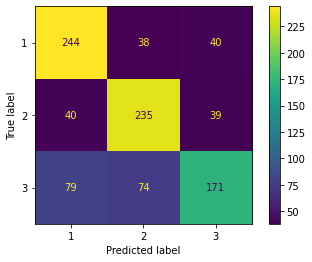


#### results for lowest loss model ####
Accuracy of: 0.6698


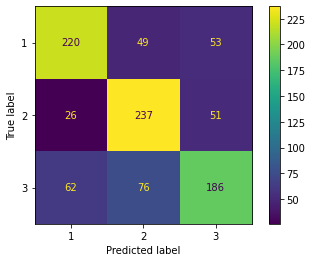


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9794 @ epoch 944
Best training loss (min) 0.1752 @ epoch 939

Best validation accuracy (max) 0.7462 @ epoch 77
Best validation loss (min) 0.6819 @ epoch 77

#### results for highest accuracy model ####
Accuracy of: 0.6058


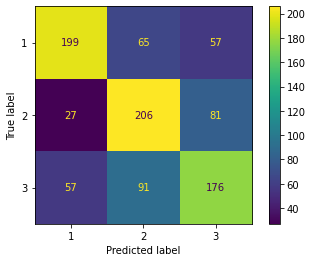


#### results for lowest loss model ####
Accuracy of: 0.6058


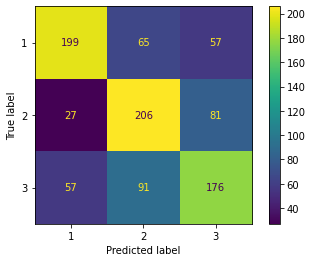


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9782 @ epoch 963
Best training loss (min) 0.1746 @ epoch 966

Best validation accuracy (max) 0.7402 @ epoch 58
Best validation loss (min) 0.6894 @ epoch 58

#### results for highest accuracy model ####
Accuracy of: 0.666


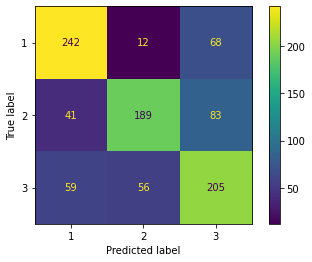


#### results for lowest loss model ####
Accuracy of: 0.666


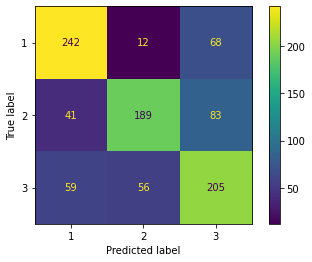

In [8]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= -0.25, tmax= 1.25)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/newsubject_longer/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## New subject: EEGNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
Perhaps the hardest task is training a classifier on data from one or more subjects, but using it to classify data from a completely new user.
This is the hardest task we'll discuss.
This section will train the same classifiers for the same participants as before but by using one participant for testing and the other two for training.

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use one participant's data for testing and the other two participant's data for training
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen subject not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
         - lstm_filters = 40
         - lstm_kernel_size = 9
         - ltsm_dropout = 0.7
         - ltsm_l1 = 0.00005
         - ltsm_l2 = 0.00005
      - We trained for 300 epochs due to the increased training time, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set


In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).summary()

In [ ]:
####################################################
# TRAINING EEGNET ON EACH SUBJECT AND TWO SESSIONS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005,
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                    # Determine the train subjects
                    train_subjects = copy.deepcopy(subject_ids_to_test)
                    train_subjects.remove(subject_id)
                    
                    mne_raws = []
                    
                    # Get all training data
                    for train_subject in train_subjects:
                        mne_raws.extend(CLA_dataset.get_all_raw_mne_data_for_subject(subject_id= train_subject))
                    
                    # Combine training data into singular mne raw
                    mne_raw = mne.concatenate_raws(mne_raws)
                    
                    # Delete all raws since concat changes them
                    del mne_raws
                    
                    # Get epochs for that MNE raw
                    mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                         start_offset= start_offset,
                                                                         end_offset= end_offset,
                                                                         baseline= baseline)
                    
                    # Only keep epochs from the MI tasks
                    mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                    
                    # Load epochs into memory
                    mne_epochs.load_data()
                    
                # Show training data
                print(f"Using data from participants {train_subjects} to train for testing on participant {subject_id}")
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all training data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_newsubject_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if nog GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= mne_epochs_data,
                                y= labels,
                                batch_size= 128, # Default: 32
                                epochs= 300, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.3,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del train_subjects
                del train_subject
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del ohe
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model

#### Results

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

EEGNet with biderectional LSTM conv:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7497 @ epoch 82                              | 0.6353 @ epoch 47                          | 0.626                                                      | 0.6125                                                      |
| C           | 0.7329 @ epoch 50                              | 0.6575 @ epoch 109                         | 0.6204                                                     | 0.5746                                                      |
| E           | 0.724 @ epoch 240                              | 0.6687 @ epoch 75                          | 0.6136                                                     | 0.6618                                                      |

Test set performance seems slightly better compared to EEGNet, although not by any statistical means.

The training plots are given below.
B is dark blue, C is light blue and E is light green.

![Accuracy plot](figures/7/EEGNet_convlstm/newsubject/accuracy.png)
![Loss plot](figures/7/EEGNet_convlstm/newsubject/loss.png)

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Fix scaling sensitivity as MNE stores as data * 10e-6
        X_test = X_test * 1000000
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset